# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_throat_admitted', 'duration_throat_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]#, 'count']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_throat/data_throat_record_cph_throat.txt", "w")
a.write("")
a.writelines(['data_throat_1 #with a record, #with no record: %.0f' % (data['throat_date_1'].notna().sum()), ', %.0f' % (data['throat_date_1'].isna().sum()),
              '\ndata_throat_2 #with a record, #with no record: %.0f' % (data['throat_date_2'].notna().sum()), ', %.0f' % (data['throat_date_2'].isna().sum()),
              '\ndata_throat_3 #with a record, #with no record: %.0f' % (data['throat_date_3'].notna().sum()), ', %.0f' % (data['throat_date_3'].isna().sum()),
              '\ndata_throat_4 #with a record, #with no record: %.0f' % (data['throat_date_4'].notna().sum()), ', %.0f' % (data['throat_date_4'].isna().sum()),
              '\ndata_throat_5 #with a record, #with no record: %.0f' % (data['throat_date_5'].notna().sum()), ', %.0f' % (data['throat_date_5'].isna().sum()),
              '\ndata_throat_6 #with a record, #with no record: %.0f' % (data['throat_date_6'].notna().sum()), ', %.0f' % (data['throat_date_6'].isna().sum()),
              '\ndata_throat_7 #with a record, #with no record: %.0f' % (data['throat_date_7'].notna().sum()), ', %.0f' % (data['throat_date_7'].isna().sum()),
              '\ndata_throat_8 #with a record, #with no record: %.0f' % (data['throat_date_8'].notna().sum()), ', %.0f' % (data['throat_date_8'].isna().sum()),
              '\ndata_throat_9 #with a record, #with no record: %.0f' % (data['throat_date_9'].notna().sum()), ', %.0f' % (data['throat_date_9'].isna().sum()),
              '\ndata_throat_10 #with a record, #with no record: %.0f' % (data['throat_date_10'].notna().sum()), ', %.0f' % (data['throat_date_10'].isna().sum()),
              '\ndata_throat_11 #with a record, #with no record: %.0f' % (data['throat_date_11'].notna().sum()), ', %.0f' % (data['throat_date_11'].isna().sum()),
              '\ndata_throat_12 #with a record, #with no record: %.0f' % (data['throat_date_12'].notna().sum()), ', %.0f' % (data['throat_date_12'].isna().sum()),
              '\ndata_throat_13 #with a record, #with no record: %.0f' % (data['throat_date_13'].notna().sum()), ', %.0f' % (data['throat_date_13'].isna().sum()),
              '\ndata_throat_14 #with a record, #with no record: %.0f' % (data['throat_date_14'].notna().sum()), ', %.0f' % (data['throat_date_14'].isna().sum()),
              '\ndata_throat_15 #with a record, #with no record: %.0f' % (data['throat_date_15'].notna().sum()), ', %.0f' % (data['throat_date_15'].isna().sum()),
              '\ndata_throat_16 #with a record, #with no record: %.0f' % (data['throat_date_16'].notna().sum()), ', %.0f' % (data['throat_date_16'].isna().sum()),
              '\ndata_throat_17 #with a record, #with no record: %.0f' % (data['throat_date_17'].notna().sum()), ', %.0f' % (data['throat_date_17'].isna().sum()),
              '\ndata_throat_18 #with a record, #with no record: %.0f' % (data['throat_date_18'].notna().sum()), ', %.0f' % (data['throat_date_18'].isna().sum()),
              '\ndata_throat_19 #with a record, #with no record: %.0f' % (data['throat_date_19'].notna().sum()), ', %.0f' % (data['throat_date_19'].isna().sum()),
              '\ndata_throat_20 #with a record, #with no record: %.0f' % (data['throat_date_20'].notna().sum()), ', %.0f' % (data['throat_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37117
0.0     37113
2.0     32750
3.0     25100
4.0     14763
6.0     12228
7.0      9848
5.0      8413
8.0      8011
9.0      5801
10.0     3428
11.0     1936
12.0     1347
13.0      832
14.0      574
15.0      363
16.0      194
17.0       93
18.0       60
19.0       22
20.0        4
22.0        2
21.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 12 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12])
data_throat.reset_index(inplace=True, drop=True)
data_throat.shape

(216002, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] #gp_cons_throat
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')
print(f'min date: {data_throat.date.min()}')
print(f'max date: {data_throat.date.max()}')
print(f'length of data_throat: {len(data_throat)}')

min date: 2019-01
max date: 2022-11
length of data_throat: 216002


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

print(data_throat['season'].value_counts())
print(f'\nmin date: {data_throat.date.min()}')
print(f'max date: {data_throat.date.max()}')
print(f'length: {len(data_throat)}')

summer    56553
spring    56342
winter    50222
autumn    41338
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 204455


In [24]:
# data_throat = data_throat[data_throat['date'] <= '2019-12']
# data_throat = data_throat[(data_throat['date'] >= '2020-03') & (data_throat['date']<= '2021-03')]
# data_throat = data_throat[data_throat['date'] >= '2021-04']
# print(f'min date: {data_throat.date.min()}')
# print(f'max date: {data_throat.date.max()}')

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_throat = data_throat[data_throat['admitted_throat_date'].notnull()]
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0
data_throat['event_throat_admitted'].value_counts()

0.0    142995
Name: event_throat_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days #gp_cons_throat
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1
# data_throat['event_throat_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]
data_throat['delta_throat_admitted'].value_counts()

232.0     61
49.0      56
43.0      56
86.0      55
125.0     55
          ..
1384.0     1
1296.0     1
1342.0     1
1381.0     1
1199.0     1
Name: delta_throat_admitted, Length: 1379, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_throat.loc[data_throat['delta_admitted_died'] >= 0, 'event_throat_admitted'] = 0
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0
# data_throat['event_throat_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_throat.loc[data_throat['delta_admitted_deregistered'] >= 0, 'event_throat_admitted'] = 0
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0
# data_throat['event_throat_admitted'].value_counts()

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_throat['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

172257

In [28]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)
data_throat['event_throat_admitted'].value_counts()

0.0    174114
1.0      1343
Name: event_throat_admitted, dtype: int64

In [29]:
#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30
data_throat['duration_throat_admitted'].value_counts()

30.0    174150
7.0         54
29.0        54
0.0         54
26.0        54
18.0        52
3.0         50
21.0        49
27.0        49
11.0        49
19.0        49
8.0         49
23.0        48
15.0        48
14.0        47
1.0         46
22.0        45
12.0        45
6.0         41
24.0        41
28.0        40
13.0        40
2.0         40
20.0        39
17.0        38
4.0         36
10.0        34
5.0         33
25.0        32
16.0        29
9.0         22
Name: duration_throat_admitted, dtype: int64

In [30]:
# give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1
data_throat['event_throat_admitted'].value_counts()

0.0    174108
1.0      1349
Name: event_throat_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

In [32]:
# data_throat[data_throat['duration_throat_admitted']==0][['delta_throat_admitted', 'throat_date', 'gp_cons_throat', 'admitted_throat_date', 'delta_throat_admitted', 'delta_admitted_died_deregistered', 'event_throat_admitted', 'duration_throat_admitted']]
# data_throat.loc[151:200, ['event_throat_admitted', 'duration_throat_admitted']]
# data_throat.loc[201:250, ['event_throat_admitted', 'duration_throat_admitted']].sort_values(by=['duration_throat_admitted'])
data_throat[['event_throat_admitted', 'duration_throat_admitted']].sort_values(by=['duration_throat_admitted'])

,event_throat_admitted,duration_throat_admitted
48014,1.0,1.0
201848,1.0,1.0
86034,1.0,1.0
199988,1.0,1.0
2340,1.0,1.0
...,...,...
72149,0.0,30.0
72150,0.0,30.0
72151,0.0,30.0
72142,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_throat['age'][data_throat['age'] < 0] = np.nan
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14']
# drop anybody with age less than 18
data_throat = data_throat[~(data_throat['age'] < 18)]  
print(f'Min age: {data_throat.age.min()}')

## remove died cases
#data_throat.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
# replace 0s with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
    # drop region value missing
    # data_throat['region_imp'] = data_throat['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_throat.region.isnull().sum()}')
    data_throat = data_throat[data_throat['region'].notna()]

print(f'Cound of missing values in variable region: {data_throat.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_throat.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21419
East                        10765
East Midlands               10739
South East                  10731
North West                  10689
North East                  10640
South West                  10614
Yorkshire and The Humber    10364
West Midlands               10330
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_throat.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_throat.antibacterial_brit.mean():.3f}')
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)
    # data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_throat.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_throat.antibacterial_brit.mean():.3f}')


Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.248


In [37]:
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_throat.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_throat.ethnicity.value_counts()}')
    # data_throat['ethnicity'] = data_throat['ethnicity'].astype(str)
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_throat.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_throat.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26977
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63480
5.0     7970
3.0     7864
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63480
0.0    26977
5.0     7970
3.0     7864
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_throat.columns) and (data_throat['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_throat.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_throat.smoking_status.value_counts()}')
    # data_throat['smoking_status'] = data_throat['smoking_status'].astype(str)
    data_throat['smoking_status'] = data_throat['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_throat.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_throat.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 44066
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41412
3.0    13845
2.0     6968
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    44066
1.0    41412
3.0    13845
2.0     6968
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_throat.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_throat.imd.value_counts()}')
    # data_throat['imd'] = data_throat['imd'].astype(str)
    data_throat['imd'] = data_throat['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_throat.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_throat.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    20307
4    20170
5    20147
2    20142
1    20026
0     5499
Name: imd, dtype: int64


In [40]:
data_throat['bmi_cat'] = 5
col_bmi_cat = data_throat.columns.get_loc('bmi_cat')

col_sex = data_throat.columns.get_loc('sex')
col_age = data_throat.columns.get_loc('age')
col_bmi = data_throat.columns.get_loc('bmi')

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, col_bmi] >= 30:
        data_throat.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_throat.iat[idx, col_bmi] >= 25) and (data_throat.iat[idx, col_bmi] < 30):
        data_throat.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_throat.iat[idx, col_bmi] >= 18.5) and (data_throat.iat[idx, col_bmi] < 25):
        data_throat.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_throat.iat[idx, col_bmi] < 18.5:
        data_throat.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_throat['bmi_cat'].value_counts()

1    55309
5    27197
2    11832
3     8601
4     3352
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_throat.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_throat.bmi_cat.value_counts()}')
    # data_throat['bmi_cat'] = data_throat['bmi_cat'].astype(str)
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_throat.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_throat.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    55309
5    27197
2    11832
3     8601
4     3352
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])

#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)
data_throat['ab_type_cat'].value_counts()

no             95507
0               8634
other           1316
Amoxicillin      638
Doxycycline      196
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking_status": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})
data_throat['ab_type_cat'].value_counts()

no             95507
other           9950
Amoxicillin      638
Doxycycline      196
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_throat['CCI_cat'].value_counts()

low          37445
medium       21189
very_low     19463
very_high    17326
high         10868
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)
data_throat['antibacterial_brit'].max()

data_throat['antibacterial_brit_cat'] = pd.cut(data_throat['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_throat['antibacterial_brit_cat'].value_counts()

low       61729
high      26619
medium    17943
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

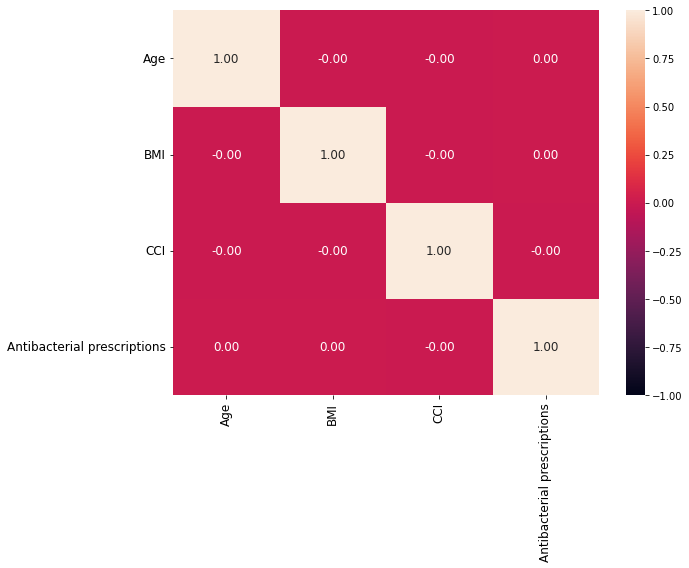

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

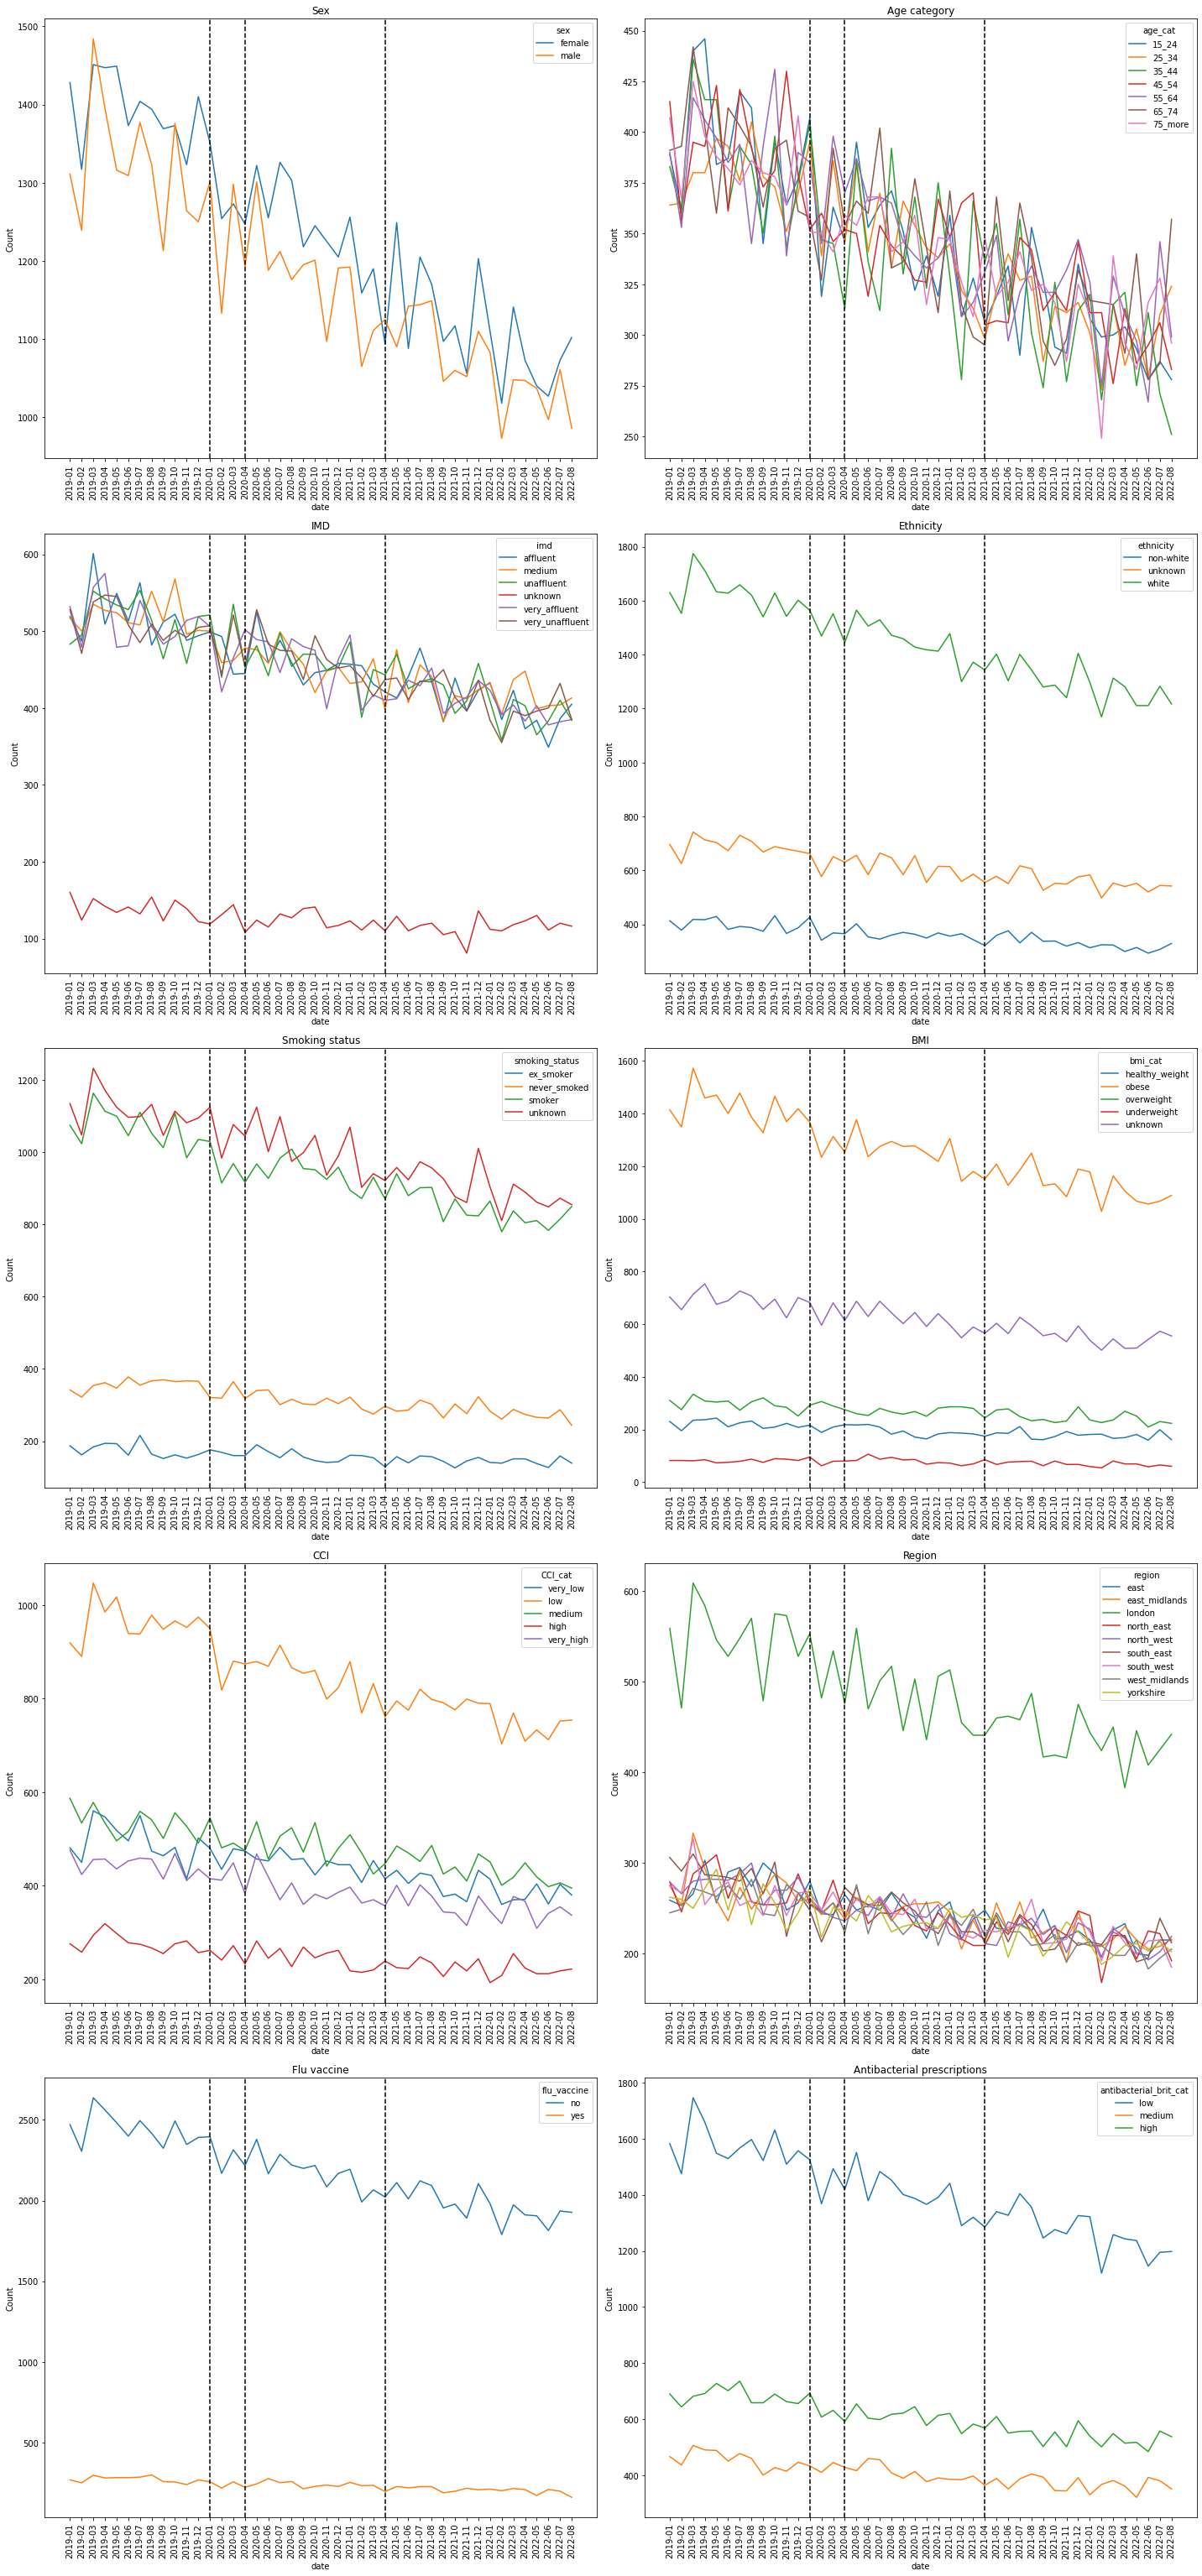

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_throat, 'sex', 'Sex', axes[0,0])
create_lineplot(data_throat, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_throat, 'imd', 'IMD', axes[1,0])
create_lineplot(data_throat, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_throat, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_throat, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_throat, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_throat, 'region', 'Region', axes[3,1])
create_lineplot(data_throat, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_throat, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of throat patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/risk_factors_cat_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of throat to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date',
                       'event_throat_admitted', 'duration_throat_admitted'
                        ]]

data_throat.shape

(106291, 17)

In [50]:
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]
#switch variable throat_ab_date into a binary variable
data_throat_incdt[['throat_ab_date']] = data_throat_incdt[['throat_ab_date']].where(data_throat_incdt[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
data_throat_prevl[['throat_ab_date']] = data_throat_prevl[['throat_ab_date']].where(data_throat_prevl[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_throat_incdt_males = data_throat_incdt[data_throat_incdt['sex'] == 'male']
data_throat_incdt_females = data_throat_incdt[data_throat_incdt['sex'] == 'female']
data_throat_prevl_males = data_throat_prevl[data_throat_prevl['sex'] == 'male']
data_throat_prevl_females = data_throat_prevl[data_throat_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_throat_incdt_15_24 = data_throat_incdt[data_throat_incdt['age_cat'] == '15_24']
data_throat_incdt_25_34 = data_throat_incdt[data_throat_incdt['age_cat'] == '25_34']
data_throat_incdt_35_44 = data_throat_incdt[data_throat_incdt['age_cat'] == '35_44']
data_throat_incdt_45_54 = data_throat_incdt[data_throat_incdt['age_cat'] == '45_54']
data_throat_incdt_55_64 = data_throat_incdt[data_throat_incdt['age_cat'] == '55_64']
data_throat_incdt_65_74 = data_throat_incdt[data_throat_incdt['age_cat'] == '65_74']
data_throat_incdt_75_more = data_throat_incdt[data_throat_incdt['age_cat'] == '75_more']
data_throat_prevl_15_24 = data_throat_prevl[data_throat_prevl['age_cat'] == '15_24']
data_throat_prevl_25_34 = data_throat_prevl[data_throat_prevl['age_cat'] == '25_34']
data_throat_prevl_35_44 = data_throat_prevl[data_throat_prevl['age_cat'] == '35_44']
data_throat_prevl_45_54 = data_throat_prevl[data_throat_prevl['age_cat'] == '45_54']
data_throat_prevl_55_64 = data_throat_prevl[data_throat_prevl['age_cat'] == '55_64']
data_throat_prevl_65_74 = data_throat_prevl[data_throat_prevl['age_cat'] == '65_74']
data_throat_prevl_75_more = data_throat_prevl[data_throat_prevl['age_cat'] == '75_more']

# #incident and prevalent infection stratified by ab categories
# data_throat_incdt_abtype_0 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[0]]
# data_throat_incdt_abtype_1 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[1]]
# data_throat_incdt_abtype_2 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[2]]
# data_throat_incdt_abtype_3 = data_throat_incdt[data_throat_incdt['ab_type_cat'] == data_throat['ab_type_cat'].unique()[3]]
# data_throat_prevl_abtype_0 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[0]]
# data_throat_prevl_abtype_1 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[1]]
# data_throat_prevl_abtype_2 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[2]]
# data_throat_prevl_abtype_3 = data_throat_prevl[data_throat_prevl['ab_type_cat'] == data_throat['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_throat_incdt_abs = data_throat_incdt[data_throat_incdt['throat_ab_date'] == 1]
# data_throat_prevl_abs = data_throat_prevl[data_throat_prevl['throat_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat[data_throat['throat_ab_date'].isnull()] #gp_cons_throat_ab
data_throat_no_abs_incdt = data_throat_no_abs_incdt[data_throat_no_abs_incdt['incdt_throat_date'] == 0]

# with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_incdt = data_throat_abs_incdt[data_throat_abs_incdt['incdt_throat_date'] == 0]

# no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_prevl = data_throat_no_abs_prevl[data_throat_no_abs_prevl['incdt_throat_date'] == 1]

# with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_prevl = data_throat_abs_prevl[data_throat_abs_prevl['incdt_throat_date'] == 1]

print(f'shape of data_throat_incdt: {data_throat_incdt.shape}')
print(f'shape of data_throat_prevl: {data_throat_prevl.shape}')
print(f'shape of data_throat_no_abs_incdt: {data_throat_no_abs_incdt.shape}')
print(f'shape of data_throat_abs_incdt: {data_throat_abs_incdt.shape}')
print(f'shape of data_throat_no_abs_prevl: {data_throat_no_abs_prevl.shape}')
print(f'shape of data_throat_abs_prevl: {data_throat_abs_prevl.shape}')
print(f'\nvalue counts of data_throat_no_abs_incdt: \n{data_throat_no_abs_incdt.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_abs_incdt: \n{data_throat_abs_incdt.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_no_abs_prevl: \n{data_throat_no_abs_prevl.event_throat_admitted.value_counts()}')
print(f'value counts of data_throat_abs_prevl: \n{data_throat_abs_prevl.event_throat_admitted.value_counts()}')

shape of data_throat_incdt: (95661, 17)
shape of data_throat_prevl: (10630, 17)
shape of data_throat_no_abs_incdt: (85874, 17)
shape of data_throat_abs_incdt: (9787, 17)
shape of data_throat_no_abs_prevl: (9633, 17)
shape of data_throat_abs_prevl: (997, 17)

value counts of data_throat_no_abs_incdt: 
0.0    85231
1.0      643
Name: event_throat_admitted, dtype: int64
value counts of data_throat_abs_incdt: 
0.0    9713
1.0      74
Name: event_throat_admitted, dtype: int64
value counts of data_throat_no_abs_prevl: 
0.0    9569
1.0      64
Name: event_throat_admitted, dtype: int64
value counts of data_throat_abs_prevl: 
0.0    992
1.0      5
Name: event_throat_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 64405 total observations, 63939 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 64405
number of events observed = 466
   partial log-likelihood = -5139.57
         time fit was run = 2022-11-15 11:11:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
CCI_cat[T.medium]               -0.21       0.81       0.15            -0.51             0.09                 0.60                 1.10
CCI_cat[T.high]                 -0.19       0.82       0.19            -0.56             0.18                 0.57                 1.19
CCI_cat[T.very_high]             0.03       1.03       0.15            -0.26             0.33                 0.77                 1.40
age_cat[T.25_34]                -0.36       0.70       0.18            -0.71            -0.01                 0.49                 0.99
age_cat[T.35_44]                -0.18       0.83       0.17            -0.51             0.15                 0.60                 1.16
age_cat[T.45_54]                -0.09       0.92       0.16            -0.41             0.23                 0.67                 1.26
age_cat[T.55_64]                -0.17       0.84       0.17            -0.50             0.16                 0.61                 1.17
age_cat[T.65_74]                -0.22       0.80       0.17            -0.55             0.11                 0.58                 1.12
age_cat[T.75_more]              -0.11       0.90       0.16            -0.43             0.21                 0.65                 1.24
antibacterial_brit              -0.05       0.96       0.03            -0.11             0.02                 0.90                 1.02
bmi_cat[T.obese]                 0.30       1.36       0.19            -0.07             0.68                 0.93                 1.98
bmi_cat[T.overweight]            0.30       1.35       0.23            -0.15             0.74                 0.86                 2.10
bmi_cat[T.underweight]           0.40       1.49       0.30            -0.19             1.00                 0.82                 2.71
bmi_cat[T.unknown]               0.11       1.11       0.21            -0.30             0.51                 0.74                 1.67
ethnicity[T.unknown]             0.05       1.05       0.15            -0.25             0.35                 0.78                 1.42
ethnicity[T.white]               0.03       1.03       0.14            -0.24             0.29                 0.79                 1.34
flu_vaccine[T.yes]               0.03       1.03       0.15            -0.27             0.33                 0.76                 1.40
imd[T.medium]                   -0.02       0.98       0.15            -0.32             0.27                 0.72                 1.32
imd[T.unaffluent]                0.07       1.07       0.15            -0.23             0.36                 0.80                 1.43
imd[T.unknown]                   0.05       1.05       0.23            -0.40             0.49                 0.67                 1.64
imd[T.very_affluent]            -0.08       0.92       0.15            -0.38             0.22                 0.68                 1.25
imd[T.very_unaffluent]           0.06       1.06       0.15            -0.23             0.36                 0.79                 1.43
region[T.east_midlands]         -0.49       0.61       0.21            -0.90            -0.09                 0.41                 0.92
region[T.london]                -0.30       0.74       0.17     

12785


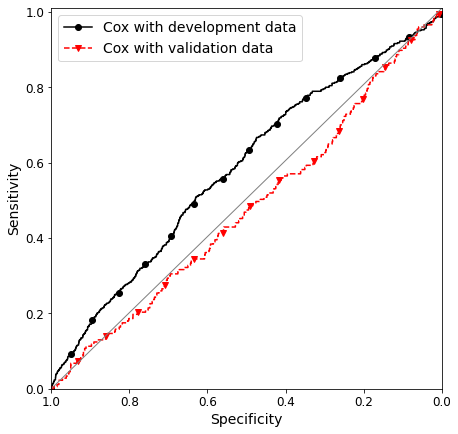

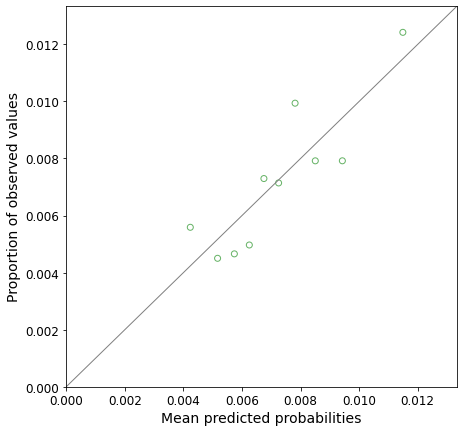

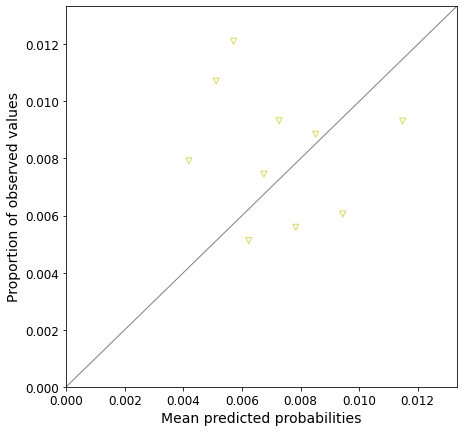

In [52]:
#data prep
data, data_throat_no_abs_incdt_enc = cox_data_prep(data_throat_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_incdt', data_throat_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_incdt', data_throat_no_abs_incdt)

#build cox model 
cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test = cox_model_build('throat', 'no_abs_incdt', data_throat_no_abs_incdt)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_throat_no_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_incdt.csv', data_throat_no_abs_incdt_enc, data_throat_no_abs_incdt, 'sum_betas_cph_throat_no_abs_incdt.csv')

#plot roc curve
cph_roc_curve(cph_throat_no_abs_incdt, 'event_throat_admitted', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_incdt.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_throat_no_abs_incdt, data_throat_no_abs_incdt_train, 'event_throat_admitted', data_throat_no_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_incdt_train.jpg', 'calibration_cph_throat_no_abs_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_throat_no_abs_incdt, 'throat', 'no_abs_incdt', data_throat_no_abs_incdt_train, data_throat_no_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-2- incident throat with antibiotics

<lifelines.CoxPHFitter: fitted with 7340 total observations, 7287 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7340
number of events observed = 53
   partial log-likelihood = -448.90
         time fit was run = 2022-11-15 11:11:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.37            -1.06             0.37                 0.35                 1.45
CCI_cat[T.medium]               -0.37       0.69       0.44            -1.22             0.48                 0.29                 1.62
CCI_cat[T.high]                  0.19       1.21       0.44            -0.67             1.04                 0.51                 2.84
CCI_cat[T.very_high]            -0.96       0.38       0.57            -2.09             0.16                 0.12                 1.17
age_cat[T.25_34]                -0.53       0.59       0.65            -1.79             0.74                 0.17                 2.10
age_cat[T.35_44]                 0.93       2.53       0.48            -0.02             1.87                 0.98                 6.49
age_cat[T.45_54]                -0.10       0.90       0.58            -1.24             1.03                 0.29                 2.80
age_cat[T.55_64]                -0.20       0.82       0.61            -1.39             0.99                 0.25                 2.69
age_cat[T.65_74]                -0.03       0.97       0.58            -1.17             1.10                 0.31                 3.01
age_cat[T.75_more]               0.49       1.63       0.52            -0.53             1.51                 0.59                 4.51
antibacterial_brit              -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
bmi_cat[T.obese]                -0.69       0.50       0.43            -1.54             0.16                 0.21                 1.17
bmi_cat[T.overweight]           -0.68       0.51       0.59            -1.83             0.48                 0.16                 1.61
bmi_cat[T.underweight]         -16.35       0.00    2232.95         -4392.85          4360.14                 0.00                  inf
bmi_cat[T.unknown]              -0.27       0.76       0.45            -1.15             0.61                 0.32                 1.84
ethnicity[T.unknown]            -0.32       0.72       0.41            -1.13             0.48                 0.32                 1.62
ethnicity[T.white]              -0.48       0.62       0.36            -1.17             0.22                 0.31                 1.25
flu_vaccine[T.yes]              -0.33       0.72       0.52            -1.35             0.70                 0.26                 2.01
imd[T.medium]                    0.55       1.73       0.51            -0.45             1.55                 0.64                 4.70
imd[T.unaffluent]                0.53       1.70       0.52            -0.48             1.55                 0.62                 4.69
imd[T.unknown]                   0.62       1.85       0.71            -0.77             2.01                 0.46                 7.45
imd[T.very_affluent]             0.40       1.49       0.53            -0.64             1.44                 0.53                 4.20
imd[T.very_unaffluent]           0.85       2.33       0.49            -0.11             1.80                 0.89                 6.08
region[T.east_midlands]         -0.18       0.83       0.61            -1.38             1.01                 0.25                 2.75
region[T.london]                -0.27       0.76       0.53          

12790


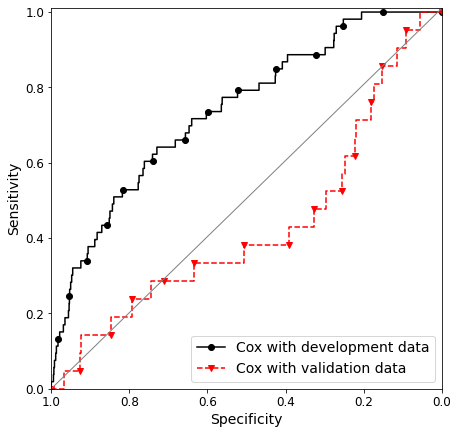

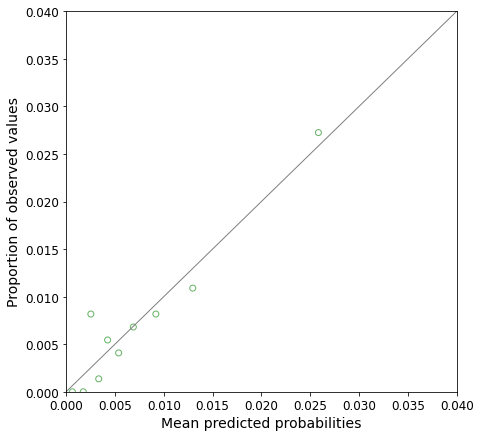

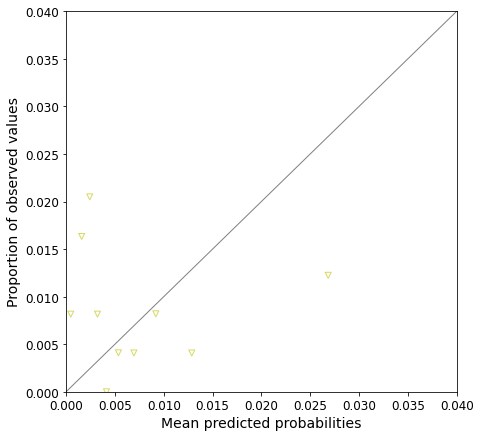

In [53]:
#data prep
data, data_throat_abs_incdt_enc = cox_data_prep(data_throat_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_incdt', data_throat_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_incdt', data_throat_abs_incdt)

#build cox model 
cph_throat_abs_incdt, data_throat_abs_incdt_train, data_throat_abs_incdt_test = cox_model_build('throat', 'abs_incdt', data_throat_abs_incdt)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_throat_abs_incdt, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_incdt.csv', data_throat_abs_incdt_enc, data_throat_abs_incdt, 'sum_betas_cph_throat_abs_incdt.csv')

#plot roc curve
cph_roc_curve(cph_throat_abs_incdt, 'event_throat_admitted', data_throat_abs_incdt_train, data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_incdt.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_throat_abs_incdt, data_throat_abs_incdt_train, 'event_throat_admitted', data_throat_abs_incdt_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_incdt_train.jpg', 'calibration_cph_throat_abs_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_throat_abs_incdt, 'throat', 'abs_incdt', data_throat_abs_incdt_train, data_throat_abs_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-3- prevalent throat with no antibiotics

<lifelines.CoxPHFitter: fitted with 7224 total observations, 7168 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 7224
number of events observed = 56
   partial log-likelihood = -478.44
         time fit was run = 2022-11-15 11:11:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.40            -0.89             0.68                 0.41                 1.97
CCI_cat[T.medium]               -0.21       0.81       0.46            -1.11             0.70                 0.33                 2.01
CCI_cat[T.high]                  0.45       1.57       0.46            -0.45             1.35                 0.64                 3.87
CCI_cat[T.very_high]             0.21       1.23       0.44            -0.65             1.07                 0.52                 2.91
age_cat[T.25_34]                -0.71       0.49       0.55            -1.79             0.37                 0.17                 1.44
age_cat[T.35_44]                -0.48       0.62       0.52            -1.50             0.54                 0.22                 1.71
age_cat[T.45_54]                -0.16       0.85       0.48            -1.10             0.77                 0.33                 2.16
age_cat[T.55_64]                -0.19       0.83       0.48            -1.12             0.75                 0.33                 2.11
age_cat[T.65_74]                -0.57       0.56       0.52            -1.59             0.44                 0.20                 1.56
age_cat[T.75_more]               0.25       1.29       0.42            -0.58             1.08                 0.56                 2.95
antibacterial_brit               0.01       1.01       0.09            -0.18             0.19                 0.84                 1.21
bmi_cat[T.obese]                 0.45       1.57       0.61            -0.74             1.64                 0.48                 5.14
bmi_cat[T.overweight]           -0.84       0.43       0.91            -2.63             0.95                 0.07                 2.60
bmi_cat[T.underweight]           0.37       1.44       0.92            -1.43             2.17                 0.24                 8.72
bmi_cat[T.unknown]               0.59       1.81       0.63            -0.63             1.82                 0.53                 6.16
ethnicity[T.unknown]             0.53       1.70       0.52            -0.48             1.55                 0.62                 4.70
ethnicity[T.white]               0.55       1.73       0.48            -0.39             1.48                 0.68                 4.41
flu_vaccine[T.yes]              -0.30       0.74       0.52            -1.32             0.72                 0.27                 2.05
imd[T.medium]                    0.25       1.28       0.43            -0.59             1.09                 0.55                 2.98
imd[T.unaffluent]               -0.06       0.94       0.46            -0.96             0.84                 0.38                 2.32
imd[T.unknown]                  -0.28       0.76       0.78            -1.80             1.24                 0.17                 3.46
imd[T.very_affluent]             0.35       1.42       0.42            -0.46             1.17                 0.63                 3.21
imd[T.very_unaffluent]          -0.13       0.87       0.46            -1.04             0.77                 0.35                 2.16
region[T.east_midlands]          0.01       1.01       0.82            -1.59             1.62                 0.20                 5.03
region[T.london]                 0.38       1.46       0.67          

12763


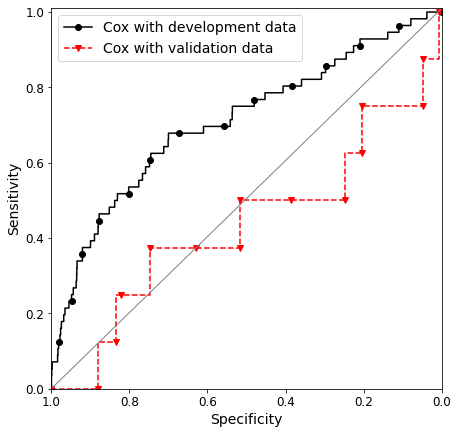

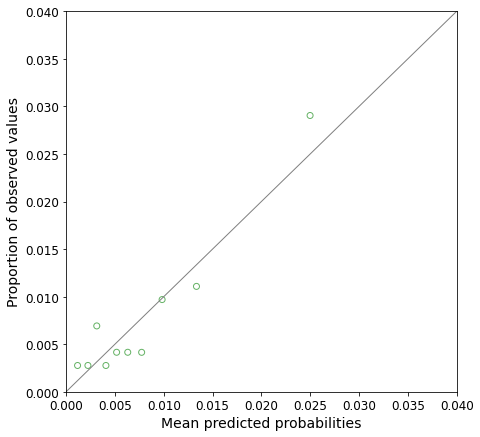

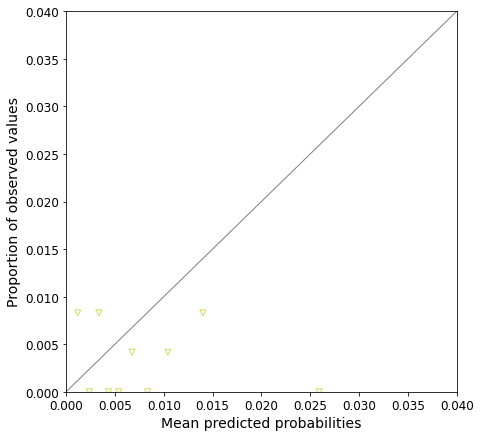

In [54]:
#data prep
data, data_throat_no_abs_prevl_enc = cox_data_prep(data_throat_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'no_abs_prevl', data_throat_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'no_abs_prevl', data_throat_no_abs_prevl)

#build cox model 
cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test = cox_model_build('throat', 'no_abs_prevl', data_throat_no_abs_prevl)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_throat_no_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_no_abs_prevl.csv', data_throat_no_abs_prevl_enc, data_throat_no_abs_prevl, 'sum_betas_cph_throat_no_abs_prevl.csv')

#plot roc curve
cph_roc_curve(cph_throat_no_abs_prevl, 'event_throat_admitted', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_no_abs_prevl.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_throat_no_abs_prevl, data_throat_no_abs_prevl_train, 'event_throat_admitted', data_throat_no_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_no_abs_prevl_train.jpg', 'calibration_cph_throat_no_abs_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_throat_no_abs_prevl, 'throat', 'no_abs_prevl', data_throat_no_abs_prevl_train, data_throat_no_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-4- prevalent throat with antibiotics

In [55]:
#data prep
data, data_throat_abs_prevl_enc = cox_data_prep(data_throat_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary table
make_summary_table('throat', 'abs_prevl', data_throat_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('throat', 'abs_prevl', data_throat_abs_prevl)

#build cox model 
cph_throat_abs_prevl, data_throat_abs_prevl_train, data_throat_abs_prevl_test = cox_model_build('throat', 'abs_prevl', data_throat_abs_prevl)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_throat_abs_prevl, '../output/hospitalisation_prediction_throat/', 'betas_cph_throat_abs_prevl.csv', data_throat_abs_prevl_enc, data_throat_abs_prevl, 'sum_betas_cph_throat_abs_prevl.csv')

#plot roc curve
cph_roc_curve(cph_throat_abs_prevl, 'event_throat_admitted', data_throat_abs_prevl_train, data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat', 'roc_cph_throat_abs_prevl.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_throat_abs_prevl, data_throat_abs_prevl_train, 'event_throat_admitted', data_throat_abs_prevl_test, '../output/hospitalisation_prediction_throat/', 'calibration_cph_throat_abs_prevl_train.jpg', 'calibration_cph_throat_abs_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_throat_abs_prevl, 'throat', 'abs_prevl', data_throat_abs_prevl_train, data_throat_abs_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

### 5-5- incident throat

<lifelines.CoxPHFitter: fitted with 72173 total observations, 71628 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 72173
number of events observed = 545
   partial log-likelihood = -6065.10
         time fit was run = 2022-11-15 10:47:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.12            -0.28             0.19                 0.76                 1.21
CCI_cat[T.medium]               -0.16       0.86       0.14            -0.43             0.12                 0.65                 1.12
CCI_cat[T.high]                 -0.01       0.99       0.16            -0.32             0.31                 0.73                 1.36
CCI_cat[T.very_high]            -0.19       0.82       0.15            -0.49             0.10                 0.61                 1.10
age_cat[T.25_34]                -0.32       0.73       0.16            -0.63            -0.01                 0.53                 0.99
age_cat[T.35_44]                -0.15       0.86       0.15            -0.45             0.15                 0.64                 1.17
age_cat[T.45_54]                -0.19       0.83       0.15            -0.49             0.12                 0.61                 1.12
age_cat[T.55_64]                -0.28       0.76       0.16            -0.59             0.03                 0.56                 1.03
age_cat[T.65_74]                 0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
age_cat[T.75_more]              -0.32       0.72       0.16            -0.64            -0.01                 0.53                 0.99
antibacterial_brit               0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
bmi_cat[T.obese]                 0.19       1.21       0.16            -0.13             0.51                 0.88                 1.67
bmi_cat[T.overweight]           -0.12       0.88       0.21            -0.53             0.29                 0.59                 1.33
bmi_cat[T.underweight]          -0.14       0.87       0.31            -0.75             0.46                 0.47                 1.59
bmi_cat[T.unknown]              -0.17       0.85       0.18            -0.52             0.19                 0.59                 1.21
ethnicity[T.unknown]             0.03       1.04       0.14            -0.23             0.30                 0.79                 1.35
ethnicity[T.white]              -0.10       0.90       0.12            -0.34             0.14                 0.71                 1.15
flu_vaccine[T.yes]              -0.00       1.00       0.14            -0.29             0.28                 0.75                 1.32
imd[T.medium]                    0.26       1.30       0.14            -0.02             0.54                 0.98                 1.72
imd[T.unaffluent]                0.16       1.17       0.15            -0.13             0.44                 0.88                 1.56
imd[T.unknown]                   0.44       1.55       0.20             0.05             0.83                 1.05                 2.29
imd[T.very_affluent]             0.21       1.24       0.14            -0.07             0.50                 0.93                 1.64
imd[T.very_unaffluent]           0.14       1.15       0.15            -0.15             0.43                 0.86                 1.53
region[T.east_midlands]         -0.34       0.71       0.21            -0.76             0.07                 0.47                 1.07
region[T.london]                 0.07       1.07       0.16         

13046


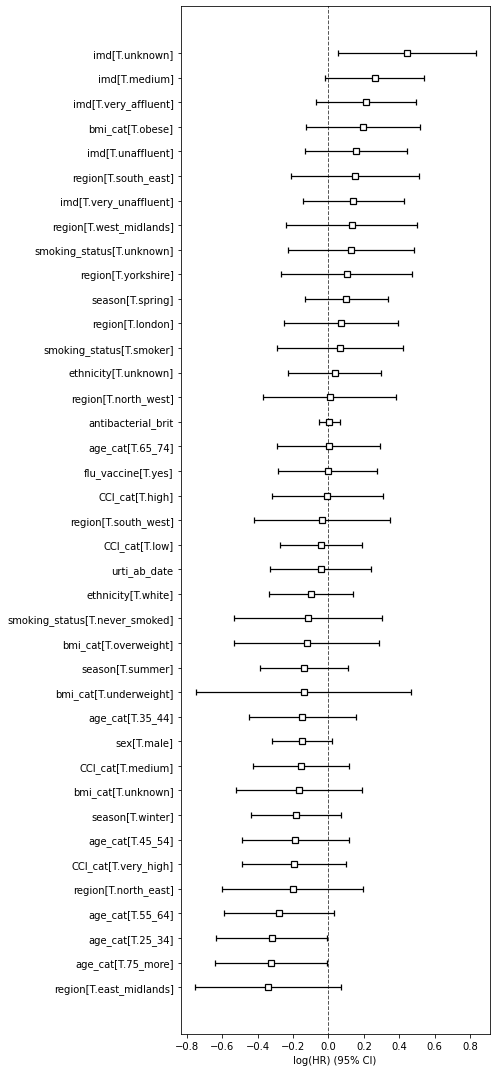

In [ ]:
#data prep
data, data_throat_incdt_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'incdt', data_throat_incdt_enc)
make_summary_table_hosped('throat', 'incdt', data_throat_incdt)

cph_throat_incdt, data_throat_incdt_train, data_throat_incdt_test = cox_model_abs_build('throat', 'incdt', data_throat_incdt)

# calculate c-statistics
cph_output(cph_throat_incdt, 'throat', 'incdt', data_throat_incdt_train, data_throat_incdt_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-6- hospital admission related to prevalent throat

<lifelines.CoxPHFitter: fitted with 7992 total observations, 7927 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7992
number of events observed = 65
   partial log-likelihood = -560.82
         time fit was run = 2022-11-15 10:47:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.39            -0.44             1.10                 0.65                 3.00
CCI_cat[T.medium]                0.45       1.57       0.42            -0.38             1.28                 0.69                 3.60
CCI_cat[T.high]                  0.52       1.68       0.47            -0.41             1.45                 0.67                 4.26
CCI_cat[T.very_high]            -0.06       0.94       0.49            -1.01             0.90                 0.36                 2.45
age_cat[T.25_34]                -0.57       0.56       0.52            -1.59             0.44                 0.20                 1.55
age_cat[T.35_44]                 0.20       1.23       0.43            -0.64             1.05                 0.53                 2.85
age_cat[T.45_54]                -0.12       0.89       0.46            -1.02             0.79                 0.36                 2.19
age_cat[T.55_64]                -0.31       0.74       0.49            -1.28             0.66                 0.28                 1.94
age_cat[T.65_74]                 0.31       1.37       0.41            -0.49             1.12                 0.61                 3.06
age_cat[T.75_more]              -0.50       0.61       0.52            -1.51             0.51                 0.22                 1.67
antibacterial_brit              -0.05       0.95       0.09            -0.22             0.12                 0.80                 1.13
bmi_cat[T.obese]                -0.36       0.70       0.42            -1.19             0.47                 0.31                 1.60
bmi_cat[T.overweight]           -0.11       0.90       0.52            -1.13             0.91                 0.32                 2.48
bmi_cat[T.underweight]         -16.04       0.00    2002.15         -3940.18          3908.11                 0.00                  inf
bmi_cat[T.unknown]               0.01       1.01       0.44            -0.85             0.87                 0.43                 2.38
ethnicity[T.unknown]             0.07       1.07       0.44            -0.80             0.94                 0.45                 2.56
ethnicity[T.white]               0.27       1.31       0.39            -0.49             1.03                 0.61                 2.79
flu_vaccine[T.yes]              -1.93       0.15       1.01            -3.91             0.05                 0.02                 1.05
imd[T.medium]                    0.54       1.71       0.45            -0.35             1.42                 0.71                 4.14
imd[T.unaffluent]                0.46       1.58       0.46            -0.44             1.35                 0.64                 3.88
imd[T.unknown]                   0.73       2.07       0.61            -0.48             1.93                 0.62                 6.92
imd[T.very_affluent]             0.74       2.10       0.43            -0.11             1.59                 0.90                 4.92
imd[T.very_unaffluent]           0.45       1.56       0.46            -0.45             1.34                 0.64                 3.84
region[T.east_midlands]         -0.24       0.79       0.67            -1.56             1.08                 0.21                 2.94
region[T.london]                 0.46       1.58       0.51            -0

13033


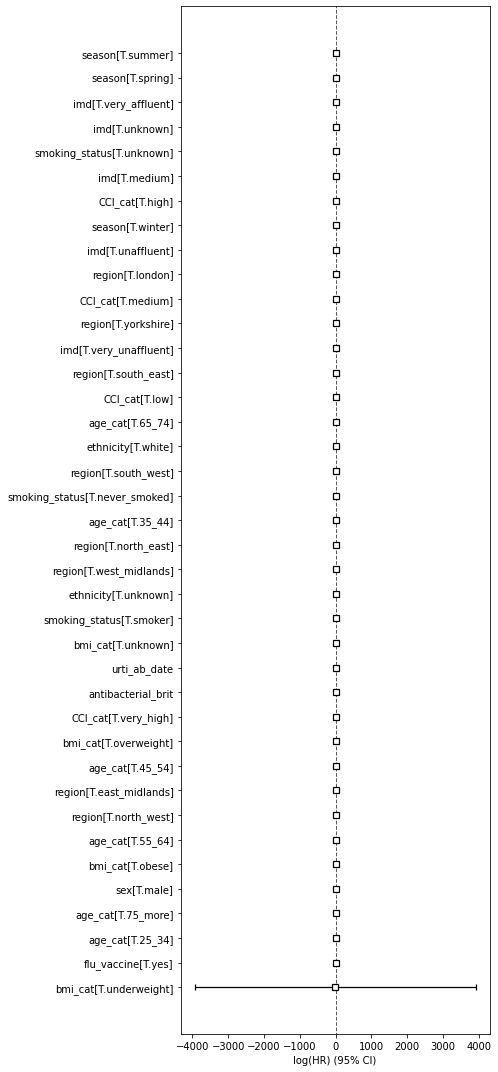

In [ ]:
#data prep
data, data_throat_prevl_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#make summary tables from preped data
make_summary_table('throat', 'prevl', data_throat_prevl_enc)
make_summary_table_hosped('throat', 'prevl', data_throat_prevl)

cph_throat_prevl, data_throat_prevl_train, data_throat_prevl_test = cox_model_abs_build('throat', 'prevl', data_throat_prevl)

# calculate c-statistics
cph_output(cph_throat_prevl, 'throat', 'prevl', data_throat_prevl_train, data_throat_prevl_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-7- hospital admission related to incident throat with antibiotics categories

<lifelines.CoxPHFitter: fitted with 72173 total observations, 71628 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 72173
number of events observed = 545
   partial log-likelihood = -6065.09
         time fit was run = 2022-11-15 10:47:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.12            -0.28             0.19                 0.76                 1.21
CCI_cat[T.medium]               -0.16       0.86       0.14            -0.43             0.12                 0.65                 1.12
CCI_cat[T.high]                 -0.01       0.99       0.16            -0.32             0.31                 0.73                 1.36
CCI_cat[T.very_high]            -0.19       0.82       0.15            -0.49             0.10                 0.61                 1.10
ab_type_cat[T.Doxycycline]      -0.08       0.92       1.15            -2.35             2.18                 0.10                 8.85
ab_type_cat[T.no]                0.08       1.08       0.58            -1.05             1.22                 0.35                 3.37
ab_type_cat[T.other]             0.04       1.04       0.60            -1.13             1.21                 0.32                 3.35
age_cat[T.25_34]                -0.32       0.73       0.16            -0.63            -0.01                 0.53                 0.99
age_cat[T.35_44]                -0.15       0.86       0.15            -0.45             0.15                 0.64                 1.17
age_cat[T.45_54]                -0.19       0.83       0.15            -0.49             0.12                 0.61                 1.12
age_cat[T.55_64]                -0.28       0.76       0.16            -0.59             0.03                 0.56                 1.03
age_cat[T.65_74]                 0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
age_cat[T.75_more]              -0.32       0.72       0.16            -0.64            -0.01                 0.53                 0.99
antibacterial_brit               0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
bmi_cat[T.obese]                 0.19       1.21       0.16            -0.13             0.51                 0.88                 1.67
bmi_cat[T.overweight]           -0.12       0.88       0.21            -0.53             0.29                 0.59                 1.33
bmi_cat[T.underweight]          -0.14       0.87       0.31            -0.75             0.46                 0.47                 1.59
bmi_cat[T.unknown]              -0.17       0.85       0.18            -0.52             0.19                 0.59                 1.21
ethnicity[T.unknown]             0.03       1.04       0.14            -0.23             0.30                 0.79                 1.35
ethnicity[T.white]              -0.10       0.90       0.12            -0.34             0.14                 0.71                 1.15
flu_vaccine[T.yes]              -0.00       1.00       0.14            -0.29             0.28                 0.75                 1.32
imd[T.medium]                    0.26       1.30       0.14            -0.02             0.54                 0.98                 1.72
imd[T.unaffluent]                0.16       1.17       0.15            -0.13             0.44                 0.88                 1.56
imd[T.unknown]                   0.44       1.55       0.20             0.05             0.83                 1.05                 2.29
imd[T.very_affluent]             0.21       1.24       0.14         

13609


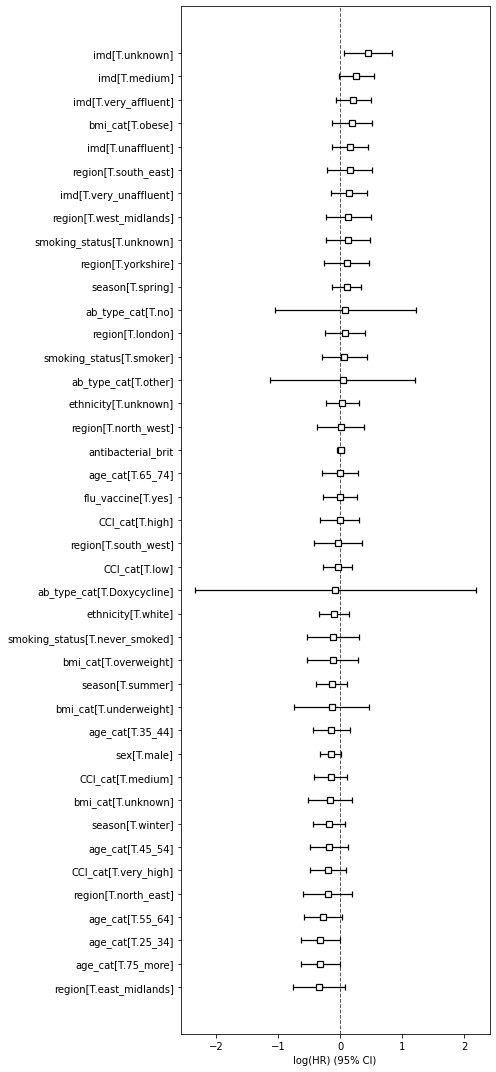

In [ ]:
#data prep
data, data_throat_incdt_abs_enc = cox_data_prep(data_throat_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_abs, data_throat_incdt_abs_train, data_throat_incdt_abs_test = cox_model_ab_type_build('throat', 'incdt_ab_type', data_throat_incdt)

# calculate c-statistics
cph_output(cph_throat_incdt_abs, 'throat', 'incdt_abs', data_throat_incdt_abs_train, data_throat_incdt_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-8- hospital admission related to prevalent throat with antibiotics categories

<lifelines.CoxPHFitter: fitted with 7992 total observations, 7927 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7992
number of events observed = 65
   partial log-likelihood = -560.42
         time fit was run = 2022-11-15 10:47:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.39            -0.44             1.10                 0.64                 2.99
CCI_cat[T.medium]                0.44       1.55       0.42            -0.39             1.27                 0.68                 3.55
CCI_cat[T.high]                  0.51       1.67       0.47            -0.41             1.44                 0.66                 4.23
CCI_cat[T.very_high]            -0.06       0.94       0.49            -1.02             0.89                 0.36                 2.44
ab_type_cat[T.Doxycycline]     -16.52       0.00    8134.32        -15959.48         15926.45                 0.00                  inf
ab_type_cat[T.no]               -0.83       0.43       1.01            -2.82             1.15                 0.06                 3.17
ab_type_cat[T.other]            -0.96       0.38       1.10            -3.12             1.21                 0.04                 3.34
age_cat[T.25_34]                -0.58       0.56       0.52            -1.59             0.44                 0.20                 1.55
age_cat[T.35_44]                 0.20       1.22       0.43            -0.64             1.04                 0.53                 2.83
age_cat[T.45_54]                -0.13       0.88       0.46            -1.03             0.77                 0.36                 2.17
age_cat[T.55_64]                -0.31       0.73       0.49            -1.28             0.66                 0.28                 1.93
age_cat[T.65_74]                 0.31       1.37       0.41            -0.49             1.12                 0.61                 3.05
age_cat[T.75_more]              -0.50       0.60       0.52            -1.52             0.51                 0.22                 1.67
antibacterial_brit              -0.05       0.95       0.09            -0.22             0.12                 0.80                 1.13
bmi_cat[T.obese]                -0.36       0.70       0.42            -1.19             0.47                 0.30                 1.60
bmi_cat[T.overweight]           -0.10       0.90       0.52            -1.12             0.92                 0.33                 2.50
bmi_cat[T.underweight]         -16.04       0.00    2014.84         -3965.05          3932.96                 0.00                  inf
bmi_cat[T.unknown]               0.00       1.00       0.44            -0.85             0.86                 0.43                 2.37
ethnicity[T.unknown]             0.06       1.06       0.44            -0.81             0.93                 0.45                 2.54
ethnicity[T.white]               0.26       1.30       0.39            -0.50             1.02                 0.61                 2.76
flu_vaccine[T.yes]              -1.92       0.15       1.01            -3.90             0.05                 0.02                 1.05
imd[T.medium]                    0.54       1.72       0.45            -0.34             1.42                 0.71                 4.15
imd[T.unaffluent]                0.46       1.59       0.46            -0.43             1.36                 0.65                 3.90
imd[T.unknown]                   0.74       2.09       0.61            -0.47             1.94                 0.63                 6.98
imd[T.very_affluent]             0.74       2.09       0.43            -0

13611


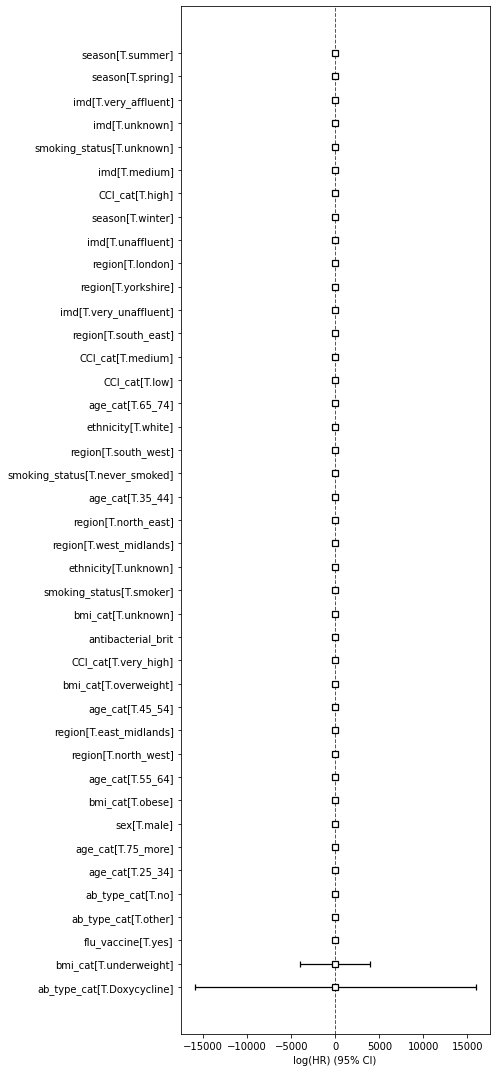

In [ ]:
#data prep
data, data_throat_prevl_abs_enc = cox_data_prep(data_throat_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_abs, data_throat_prevl_abs_train, data_throat_prevl_abs_test = cox_model_ab_type_build('throat', 'prevl_ab_type', data_throat_prevl)

# calculate c-statistics
cph_output(cph_throat_prevl_abs, 'throat', 'prevl_abs', data_throat_prevl_abs_train, data_throat_prevl_abs_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

### 5-9- stratified by sex
#### 5-9-1- incident males

In [ ]:
#data prep
data, data_throat_incdt_males_enc = cox_data_prep(data_throat_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_males, data_throat_incdt_males_train, data_throat_incdt_males_test = cox_model_strat_sex_build('throat', 'incdt_males', data_throat_incdt_males)

# calculate c-statistics
cph_output(cph_throat_incdt_males, 'throat', 'incdt_males', data_throat_incdt_males_train, data_throat_incdt_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

12777


#### 5-9-2- incident females

In [ ]:
#data prep
data, data_throat_incdt_females_enc = cox_data_prep(data_throat_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_females, data_throat_incdt_females_train, data_throat_incdt_females_test = cox_model_strat_sex_build('throat', 'incdt_females', data_throat_incdt_females)

# calculate c-statistics
cph_output(cph_throat_incdt_females, 'throat', 'incdt_females', data_throat_incdt_females_train, data_throat_incdt_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

12783


#### 5-9-3- prevalent males

In [ ]:
#data prep
data, data_throat_prevl_males_enc = cox_data_prep(data_throat_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_males, data_throat_prevl_males_train, data_throat_prevl_males_test = cox_model_strat_sex_build('throat', 'prevl_males', data_throat_prevl_males)

# calculate c-statistics
cph_output(cph_throat_prevl_males, 'throat', 'prevl_males', data_throat_prevl_males_train, data_throat_prevl_males_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

12774


#### 5-9-4- prevalent females

In [ ]:
#data prep
data, data_throat_prevl_females_enc = cox_data_prep(data_throat_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_females, data_throat_prevl_females_train, data_throat_prevl_females_test = cox_model_strat_sex_build('throat', 'prevl_females', data_throat_prevl_females)

# calculate c-statistics
cph_output(cph_throat_prevl_females, 'throat', 'prevl_females', data_throat_prevl_females_train, data_throat_prevl_females_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

12760


### 5-10- stratified by age category
#### 5-10-1- incident

In [ ]:
#data prep
data, data_throat_incdt_15_24_enc = cox_data_prep(data_throat_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_15_24, data_throat_incdt_15_24_train, data_throat_incdt_15_24_test = cox_model_strat_age_build('throat', 'incdt_15_24', data_throat_incdt_15_24)

# calculate c-statistics
cph_output(cph_throat_incdt_15_24, 'throat', 'incdt_15_24', data_throat_incdt_15_24_train, data_throat_incdt_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11402


In [ ]:
#data prep
data, data_throat_incdt_25_34_enc = cox_data_prep(data_throat_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_25_34, data_throat_incdt_25_34_train, data_throat_incdt_25_34_test = cox_model_strat_age_build('throat', 'incdt_25_34', data_throat_incdt_25_34)

# calculate c-statistics
cph_output(cph_throat_incdt_25_34, 'throat', 'incdt_25_34', data_throat_incdt_25_34_train, data_throat_incdt_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11415


In [ ]:
#data prep
data, data_throat_incdt_35_44_enc = cox_data_prep(data_throat_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_35_44, data_throat_incdt_35_44_train, data_throat_incdt_35_44_test = cox_model_strat_age_build('throat', 'incdt_35_44', data_throat_incdt_35_44)

# calculate c-statistics
cph_output(cph_throat_incdt_35_44, 'throat', 'incdt_35_44', data_throat_incdt_35_44_train, data_throat_incdt_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11400


In [ ]:
#data prep
data, data_throat_incdt_45_54_enc = cox_data_prep(data_throat_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_45_54, data_throat_incdt_45_54_train, data_throat_incdt_45_54_test = cox_model_strat_age_build('throat', 'incdt_45_54', data_throat_incdt_45_54)

# calculate c-statistics
cph_output(cph_throat_incdt_45_54, 'throat', 'incdt_45_54', data_throat_incdt_45_54_train, data_throat_incdt_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11394


In [ ]:
#data prep
data, data_throat_incdt_55_64_enc = cox_data_prep(data_throat_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_55_64, data_throat_incdt_55_64_train, data_throat_incdt_55_64_test = cox_model_strat_age_build('throat', 'incdt_55_64', data_throat_incdt_55_64)

# calculate c-statistics
cph_output(cph_throat_incdt_55_64, 'throat', 'incdt_55_64', data_throat_incdt_55_64_train, data_throat_incdt_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11401


In [ ]:
#data prep
data, data_throat_incdt_65_74_enc = cox_data_prep(data_throat_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_65_74, data_throat_incdt_65_74_train, data_throat_incdt_65_74_test = cox_model_strat_age_build('throat', 'incdt_65_74', data_throat_incdt_65_74)

# calculate c-statistics
cph_output(cph_throat_incdt_65_74, 'throat', 'incdt_65_74', data_throat_incdt_65_74_train, data_throat_incdt_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11388


In [ ]:
#data prep
data, data_throat_incdt_75_more_enc = cox_data_prep(data_throat_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_incdt_75_more, data_throat_incdt_75_more_train, data_throat_incdt_75_more_test = cox_model_strat_age_build('throat', 'incdt_75_more', data_throat_incdt_75_more)

# calculate c-statistics
cph_output(cph_throat_incdt_75_more, 'throat', 'incdt_75_more', data_throat_incdt_75_more_train, data_throat_incdt_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11397


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_throat_prevl_15_24_enc = cox_data_prep(data_throat_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_15_24, data_throat_prevl_15_24_train, data_throat_prevl_15_24_test = cox_model_strat_age_build('throat', 'prevl_15_24', data_throat_prevl_15_24)

# calculate c-statistics
cph_output(cph_throat_prevl_15_24, 'throat', 'prevl_15_24', data_throat_prevl_15_24_train, data_throat_prevl_15_24_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11653


In [ ]:
#data prep
data, data_throat_prevl_25_34_enc = cox_data_prep(data_throat_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_25_34, data_throat_prevl_25_34_train, data_throat_prevl_25_34_test = cox_model_strat_age_build('throat', 'prevl_25_34', data_throat_prevl_25_34)

# calculate c-statistics
cph_output(cph_throat_prevl_25_34, 'throat', 'prevl_25_34', data_throat_prevl_25_34_train, data_throat_prevl_25_34_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11805


In [ ]:
#data prep
data, data_throat_prevl_35_44_enc = cox_data_prep(data_throat_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_35_44, data_throat_prevl_35_44_train, data_throat_prevl_35_44_test = cox_model_strat_age_build('throat', 'prevl_35_44', data_throat_prevl_35_44)

# calculate c-statistics
cph_output(cph_throat_prevl_35_44, 'throat', 'prevl_35_44', data_throat_prevl_35_44_train, data_throat_prevl_35_44_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11460


In [ ]:
#data prep
data, data_throat_prevl_45_54_enc = cox_data_prep(data_throat_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_45_54, data_throat_prevl_45_54_train, data_throat_prevl_45_54_test = cox_model_strat_age_build('throat', 'prevl_45_54', data_throat_prevl_45_54)

# calculate c-statistics
cph_output(cph_throat_prevl_45_54, 'throat', 'prevl_45_54', data_throat_prevl_45_54_train, data_throat_prevl_45_54_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11609


In [ ]:
#data prep
data, data_throat_prevl_55_64_enc = cox_data_prep(data_throat_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_55_64, data_throat_prevl_55_64_train, data_throat_prevl_55_64_test = cox_model_strat_age_build('throat', 'prevl_55_64', data_throat_prevl_55_64)

# calculate c-statistics
cph_output(cph_throat_prevl_55_64, 'throat', 'prevl_55_64', data_throat_prevl_55_64_train, data_throat_prevl_55_64_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11662


In [ ]:
#data prep
data, data_throat_prevl_65_74_enc = cox_data_prep(data_throat_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

#cox model
cph_throat_prevl_65_74, data_throat_prevl_65_74_train, data_throat_prevl_65_74_test = cox_model_strat_age_build('throat', 'prevl_65_74', data_throat_prevl_65_74)

# calculate c-statistics
cph_output(cph_throat_prevl_65_74, 'throat', 'prevl_65_74', data_throat_prevl_65_74_train, data_throat_prevl_65_74_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11462


In [ ]:
# #data prep
# data, data_throat_prevl_75_more_enc = cox_data_prep(data_throat_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'throat_ab_date'], ['antibacterial_brit'], ['event_throat_admitted', 'duration_throat_admitted'])

# #cox model
# cph_throat_prevl_75_more, data_throat_prevl_75_more_train, data_throat_prevl_75_more_test = cox_model_strat_age_build('throat', 'prevl_75_more', data_throat_prevl_75_more)

# # calculate c-statistics
# cph_output(cph_throat_prevl_75_more, 'throat', 'prevl_75_more', data_throat_prevl_75_more_train, data_throat_prevl_75_more_test, 'event_throat_admitted', 'duration_throat_admitted', '../output/hospitalisation_prediction_throat/')

11682
